In [7]:
import pandas as pd

test = pd.read_excel("C:/intensive3/test.xlsx")

test

,dt,Цена на арматуру
0,2022-09-05,46000
1,2022-09-12,46000
2,2022-09-19,46000
3,2022-09-26,45500
4,2022-10-03,45500
5,2022-10-10,45000
6,2022-10-17,44000
7,2022-10-24,43000
8,2022-10-31,42000
9,2022-11-07,41500


0:	learn: 1.6900147	test: 1.7795131	best: 1.7795131 (0)	total: 20.4ms	remaining: 20.4s
100:	learn: 0.6657584	test: 1.9575234	best: 1.5446839 (9)	total: 1.97s	remaining: 17.5s
200:	learn: 0.4547152	test: 2.1375074	best: 1.5446839 (9)	total: 3.87s	remaining: 15.4s
300:	learn: 0.3396105	test: 2.2700345	best: 1.5446839 (9)	total: 6.01s	remaining: 14s
400:	learn: 0.2636346	test: 2.3791941	best: 1.5446839 (9)	total: 7.88s	remaining: 11.8s
500:	learn: 0.2084330	test: 2.5214964	best: 1.5446839 (9)	total: 9.76s	remaining: 9.72s
600:	learn: 0.1731936	test: 2.6183120	best: 1.5446839 (9)	total: 11.7s	remaining: 7.74s
700:	learn: 0.1461028	test: 2.7120163	best: 1.5446839 (9)	total: 13.6s	remaining: 5.8s
800:	learn: 0.1243814	test: 2.7758760	best: 1.5446839 (9)	total: 15.4s	remaining: 3.83s
900:	learn: 0.1077199	test: 2.7944903	best: 1.5446839 (9)	total: 17.3s	remaining: 1.9s
999:	learn: 0.0948702	test: 2.8452924	best: 1.5446839 (9)	total: 19.1s	remaining: 0us

bestTest = 1.54468387
bestIteration = 

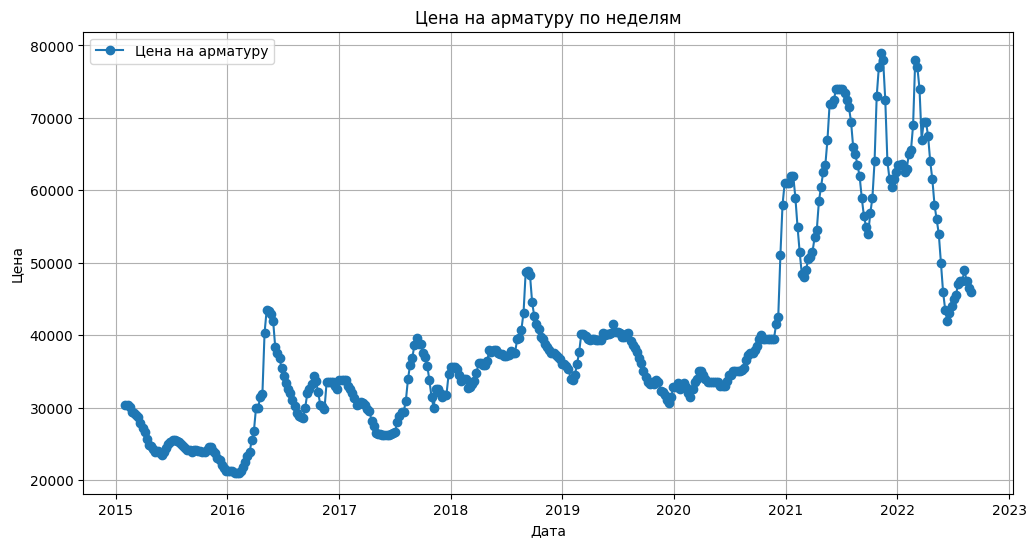

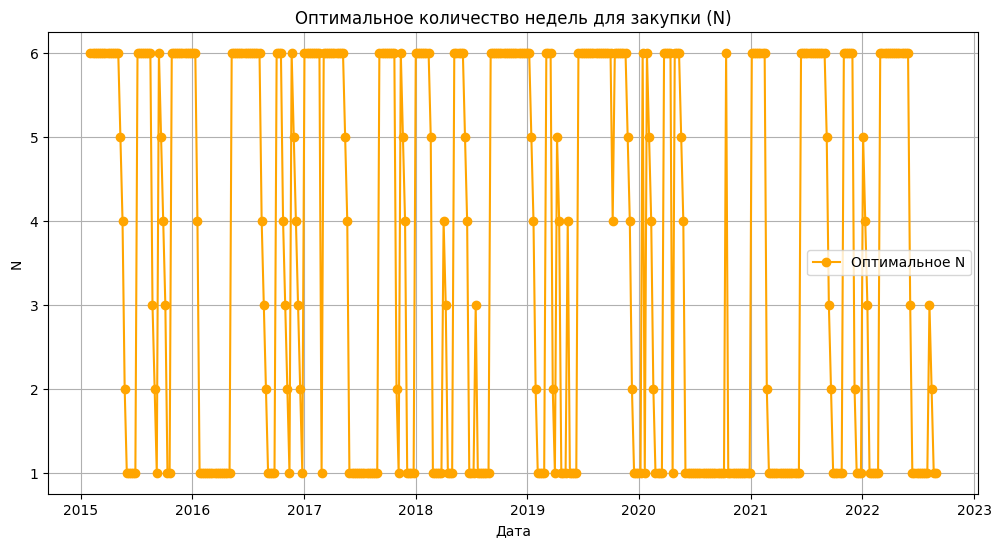

In [10]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import joblib
import matplotlib.pyplot as plt

# Загрузка данных
train_df = pd.read_excel(r'C:/intensive3/train.xlsx', parse_dates=['dt'])

# Заполнение пропусков (если они есть)
train_df.ffill(inplace=True)  # Заменяем пропуски вперед
train_df.bfill(inplace=True)  # Заменяем пропуски назад

# Расчет оптимального N для каждой даты
def calculate_optimal_n(df):
    optimal_n = []
    for i in range(len(df)):
        max_saving = -np.inf
        best_n = 1
        current_price = df.iloc[i]['Цена на арматуру']
        for n in range(1, 7):
            if i + n >= len(df):
                break
            future_prices = df.iloc[i:i+n]['Цена на арматуру']
            saving = current_price * n - future_prices.sum()
            if saving > max_saving:
                max_saving = saving
                best_n = n
        optimal_n.append(best_n)
    return optimal_n

train_df['N'] = calculate_optimal_n(train_df)

# Генерация признаков
for lag in range(1, 5):
    train_df[f'lag_{lag}'] = train_df['Цена на арматуру'].shift(lag)

train_df['ma_3'] = train_df['Цена на арматуру'].rolling(3).mean()
train_df['ma_5'] = train_df['Цена на арматуру'].rolling(5).mean()
train_df['month'] = train_df['dt'].dt.month
train_df['week_of_year'] = train_df['dt'].dt.isocalendar().week

# Удаление строк с пропусками
train_df.dropna(inplace=True)

# Разделение данных
features = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'ma_3', 'ma_5', 'month', 'week_of_year']
X = train_df[features]
y = train_df['N']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# Обучение модели
model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, verbose=100)
model.fit(X_train, y_train, eval_set=(X_val, y_val))

# Сохранение модели
joblib.dump(model, 'model.pkl')

# Визуализация цен на арматуру
plt.figure(figsize=(12, 6))
plt.plot(train_df['dt'], train_df['Цена на арматуру'], label='Цена на арматуру', marker='o')
plt.title('Цена на арматуру по неделям')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid()
plt.show()

# Визуализация предсказанных значений N
plt.figure(figsize=(12, 6))
plt.plot(train_df['dt'], train_df['N'], label='Оптимальное N', marker='o', color='orange')
plt.title('Оптимальное количество недель для закупки (N)')
plt.xlabel('Дата')
plt.ylabel('N')
plt.legend()
plt.grid()
plt.show()

MAE: 3.6666666666666665
MSE: 17.916666666666668


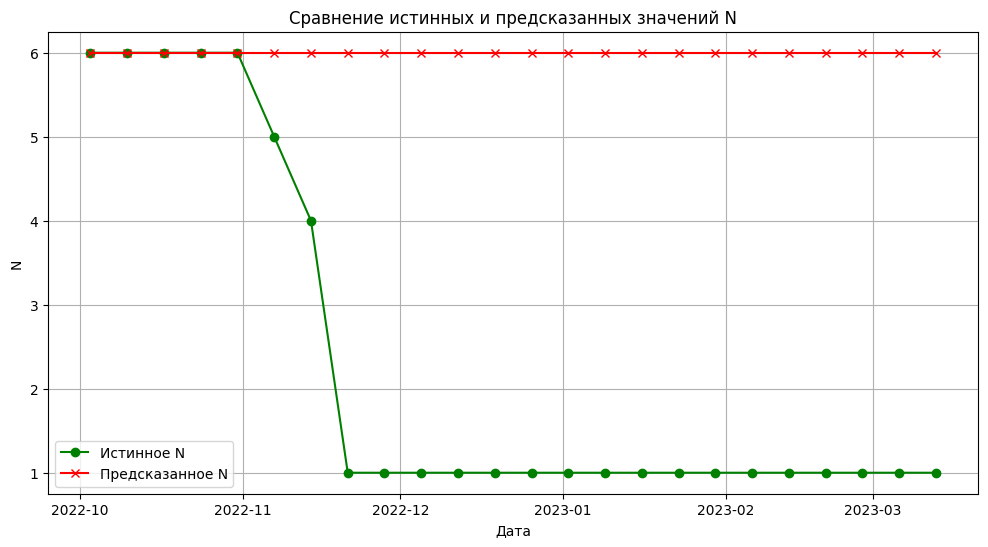

In [11]:
# Загрузка тестовых данных
test_df = pd.read_excel(r'C:/intensive3/test.xlsx', parse_dates=['dt'])

# Генерация признаков для тестовых данных
for lag in range(1, 5):
    test_df[f'lag_{lag}'] = test_df['Цена на арматуру'].shift(lag)

test_df['ma_3'] = test_df['Цена на арматуру'].rolling(3).mean().bfill()
test_df['ma_5'] = test_df['Цена на арматуру'].rolling(5).mean().bfill()
test_df['month'] = test_df['dt'].dt.month
test_df['week_of_year'] = test_df['dt'].dt.isocalendar().week

# Удаление строк с пропусками
test_df.dropna(inplace=True)

# Предсказание
test_df['N_pred'] = model.predict(test_df[features])

# Оценка качества модели
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Предположим, что у вас есть истинные значения N для тестовых данных
# Если их нет, можно использовать calculate_optimal_n для их расчета
test_df['N_true'] = calculate_optimal_n(test_df)

mae = mean_absolute_error(test_df['N_true'], test_df['N_pred'])
mse = mean_squared_error(test_df['N_true'], test_df['N_pred'])

print(f"MAE: {mae}")
print(f"MSE: {mse}")

# Визуализация предсказаний на тестовых данных
plt.figure(figsize=(12, 6))
plt.plot(test_df['dt'], test_df['N_true'], label='Истинное N', marker='o', color='green')
plt.plot(test_df['dt'], test_df['N_pred'], label='Предсказанное N', marker='x', color='red')
plt.title('Сравнение истинных и предсказанных значений N')
plt.xlabel('Дата')
plt.ylabel('N')
plt.legend()
plt.grid()
plt.show()

In [21]:
test.info

<bound method DataFrame.info of            dt  Цена на арматуру
0  2022-09-05             46000
1  2022-09-12             46000
2  2022-09-19             46000
3  2022-09-26             45500
4  2022-10-03             45500
5  2022-10-10             45000
6  2022-10-17             44000
7  2022-10-24             43000
8  2022-10-31             42000
9  2022-11-07             41500
10 2022-11-14             41000
11 2022-11-21             40000
12 2022-11-28             40000
13 2022-12-05             40500
14 2022-12-12             41700
15 2022-12-19             41700
16 2022-12-26             42500
17 2023-01-02             42700
18 2023-01-09             42700
19 2023-01-16             42700
20 2023-01-23             42800
21 2023-01-30             42800
22 2023-02-06             44500
23 2023-02-13             44500
24 2023-02-20             46000
25 2023-02-27             49200
26 2023-03-06             53700
27 2023-03-13             55500>

In [12]:
test.describe()

,dt,Цена на арматуру
count,28,28.000000
mean,2022-12-08 12:00:00,44250.000000
min,2022-09-05 00:00:00,40000.000000
25%,2022-10-22 06:00:00,41925.000000
50%,2022-12-08 12:00:00,42900.000000
75%,2023-01-24 18:00:00,45625.000000
max,2023-03-13 00:00:00,55500.000000
std,NaN,3645.951585
